In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import dill

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.prediction import loaders
from biked_commons.resource_utils import models_and_scalers_path
from biked_commons.prediction.prediction_utils import TorchStandardScaler, DNN, Preprocessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First, some visualization for the paper.

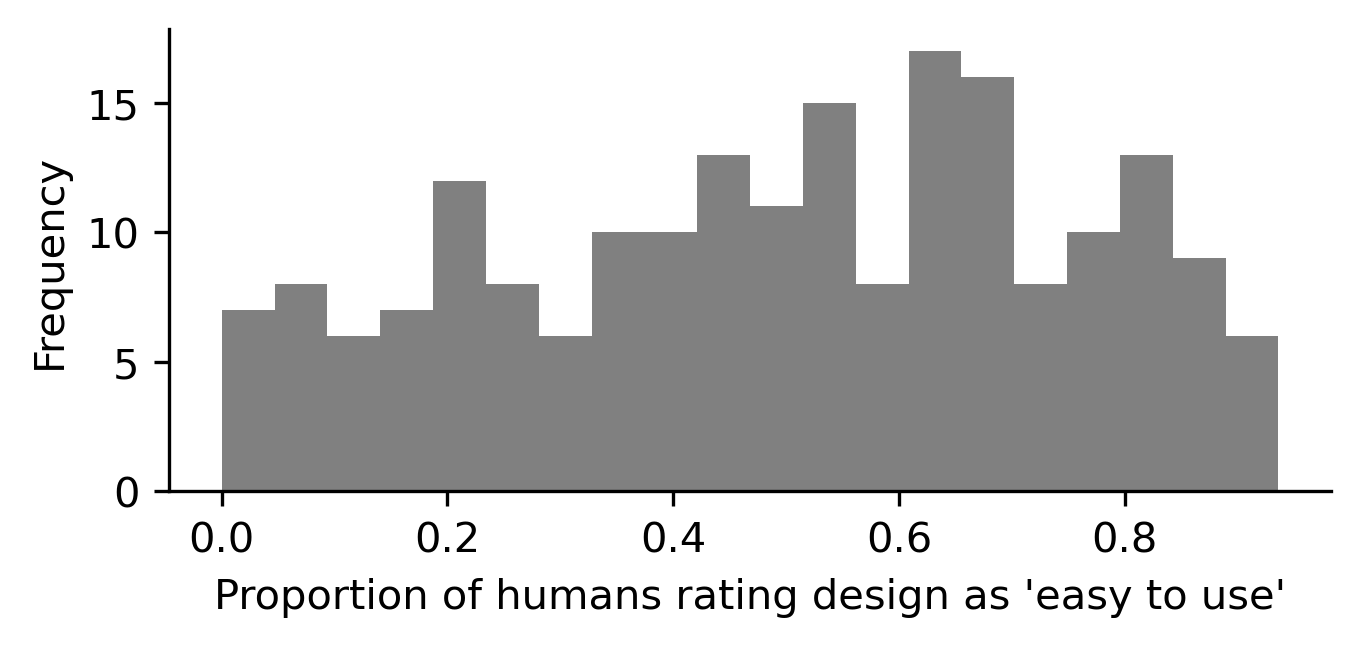

In [21]:
import pandas as pd
from biked_commons.resource_utils import split_datasets_path
train = pd.read_csv(split_datasets_path("usability_cont_Y_train.csv"))
test = pd.read_csv(split_datasets_path("usability_cont_Y_test.csv"))

concatenated = pd.concat([train, test], axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 2), dpi=300)

plt.hist(concatenated["average_rating"], bins=20,color="gray")
plt.xlabel("Proportion of humans rating design as 'easy to use'")
plt.ylabel("Frequency")
#remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [2]:
X_tv, Y_tv = loaders.load_usability("cont")
X_tv_tens = torch.tensor(X_tv.values, dtype=torch.float32, device=device)
Y_tv_tens = torch.tensor(Y_tv.values, dtype=torch.float32, device=device)

In [3]:
scaler = TorchStandardScaler().to(device)
scaler.fit(X_tv_tens)


scaler_path = models_and_scalers_path("usability_scaler.pt")
torch.save(scaler, scaler_path)

X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)

C:\Users\Lyle\AppData\Local\Temp\ipykernel_29772\2204159992.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)


For this prediction task, model and training setting were tuned using optimization in a different notebook. Therefore, cross-validation is not used here. Training/model settings are hard-coded here for simplicity.


In [4]:
X_train = X_tv_tens
Y_train = Y_tv_tens

In [5]:

input_dim = X_train.shape[1]

model = DNN(input_dim, layer_sizes = [160, 512], dropout_rate = 0.1404).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002723)

# Training loop
num_epochs = 150
batch_size = 4
best_loss = float('inf')
best_model = None

bar = trange(num_epochs, desc="Training")
for epoch in bar:
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()

    if loss.item() < best_loss:
        best_loss = loss.item()

    bar.set_postfix({
        'loss': f'{loss.item():.4f}',
        'best_loss': f'{best_loss:.4f}'
    })

best_model = model


Training: 100%|██████████| 150/150 [00:08<00:00, 17.62it/s, loss=0.0041, best_loss=0.0013]


In [6]:
save_path = models_and_scalers_path("usability_model.pt")
torch.save(best_model, save_path)

In [7]:
model = torch.load(save_path)

In [8]:
import evaluators

evaluators.evaluate_usability(model, Preprocessor(scaler_path=scaler_path, preprocess_fn=None, device=device), device=device, target_type='cont')

0.4814571653072077